
# TP3: Clasificador de imagenes


``torchvision`` contiene  data loaders para datasets conocidos como ImageNet, CIFAR10, MNIST, etc.
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

El dataset CIFAR10 contiene las siguientes clases: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
Las imagenes son de tamaño 3x32x32, i.e. imagenes de color de 3 canales (RGB) de 32x32 pixels en tamaño.


## Orden de pasos

0. Elijan GPU para que corra mas rapido (RAM --> change runtime type --> T4 GPU)
1. Cargamos los datos CIFAR10 y preparamos los sets de training, validation y test.
2. Definimos las redes. Una MLP, un una CNN
3. Definimos la loss
4. Entrenamos
5. Evaluamos en Test


## 1. Configuración
Crearse una cuenta en Weights and Biases (o en su board favorito) y linkear la notebook a este. Cada experimento deberá contener nombres dicientes y almacenar los (hiper)parámetros de configuración del mismo. Deberá separar los sets de datos en entrenamiento, validación y test. Utilizando solamente los sets de entrenamiento y validación, registrar la loss en train y validación en cada iteración que considere conveniente

In [1]:
!pip install wandb


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
import numpy as np
import wandb
import matplotlib.pyplot as plt
import os

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [4]:
# !wandb login --relogin
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: osaintnom (chicas_superpoderosas). Use `wandb login --relogin` to force relogin


True

bfbad9b2649155692b5f97a49a43c0eeb66dff4a

In [5]:
# Chequeamos si la carpeta data existe, si no existe la creamos
download = not os.path.isdir('./data')


In [6]:
torch.manual_seed(181988)
if torch.cuda.is_available():
    torch.cuda.manual_seed(181988)


In [7]:
#Parametros
batch_size =32
learning_rate = 0.02
momentum =.9
epochs = 10
num_classes = 10

# epochs = 20
# batch_size = 16
# learning_rate = 0.005
# weight_decay = 0.005
# momentum = 0.9

# experiment_name = "MLP"
# experiment_name = "fc_hl_bigvalues"
# experiment_name = "fc_hl_1layers"
# experiment_name = "fc_hl_values_and_2layers"
# experiment_name = "fc_hl_bigvalues_and_2layers"
# experiment_name = "fc_hl_less_values"
# experiment_name = "fc_hl_1layer_less"
# experiment_name = "fc_hl_1layerless_smallvalues"
# experiment_name = "cnn_lessvalues"
# experiment_name = "cnn_lessvalues_LR_MP"
# experiment_name = 'CNN_LeNet-5'
# experiment_name = 'CNN_ALexNet'
# experiment_name = 'CNN_VGG16'
experiment_name = 'CNN_ResNet-18'


project_name = "TP3"

In [8]:
name_deep_net_exp = ['MLP','fc_hl_bigvalues','fc_hl_1layers','fc_hl_values_and_2layers','fc_hl_bigvalues_and_2layers','fc_hl_less_values','fc_hl_1layer_less','fc_hl_1layerless_smallvalues','cnn_lessvalues','cnn_lessvalues_LR_MP']

name_conv_net_exp = ['CNN_LeNet-5','CNN_ALexNet','CNN_ResNet-18','CNN_VGG16']

In [9]:
# Guardamos en la variable transform un tensor de 3 dimensiones (RGB) normalizado
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


### Train Set y Validation Set

In [10]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
targets_ = trainset.targets
train_idx, val_idx = train_test_split(np.arange(len(targets_)), test_size=0.2, stratify=targets_)
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sampler,batch_size=batch_size, num_workers=2)
valloader = torch.utils.data.DataLoader(trainset, sampler=val_sampler,batch_size=batch_size, num_workers=2)


Files already downloaded and verified


### Test Set

In [11]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


### Visualizacion de Imagenes

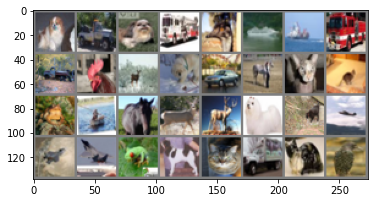

dog   truck dog   truck bird  ship  ship  truck truck bird  deer  dog   car   horse cat   cat   frog  ship  horse deer  deer  dog   cat   plane plane plane frog  dog   cat   truck cat   bird 


torch.Size([3, 32, 32])

In [12]:
%matplotlib inline

# Funcion para mostrar imagenes
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Tomar imagenes random
data_iter = iter(trainloader)
images, labels = next(data_iter)

# Mostramos imagenes
imshow(torchvision.utils.make_grid(images))

# Printeamos las etiquetas de las imagenes
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

image_size = images[0].shape
image_size


## 2. Arquitectura
Realizar experimentos variando cantidad de capas densas, nodos, hidden layers y reportar el mejor y peor experimento. ¿Qué estrategia utilizaron? ¿Qué resultados obtuvieron?

In [13]:
if experiment_name == "MLP":
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 120)
            self.fc23 = nn.Linear(120, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes) # termina con 10 para quedarse con la mejor

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x



In [14]:
if experiment_name == "fc_hl_bigvalues":
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 150)
            self.fc23 = nn.Linear(150, 150)
            self.fc2 = nn.Linear(150, 100)
            self.fc3 = nn.Linear(100, num_classes) # termina con 10 para quedarse con la mejor

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x



In [15]:
if experiment_name == "fc_hl_1layers":
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 300)
            self.fc23 = nn.Linear(300, 200)
            self.fc_hidden = nn.Linear(200, 120)  # Nueva capa oculta con 120 nodos
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes)

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc_hidden(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x


In [16]:
if experiment_name == "fc_hl_bigvalues_and_2layers":
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 300)
            self.fc23 = nn.Linear(300, 200)
            self.fc_hidden12 = nn.Linear(200, 200)  # Nueva capa oculta con 120 nodos
            self.fc2 = nn.Linear(200, 120)
            self.fc_hidden23 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes)

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc_hidden12(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc_hidden23(x))
            x = self.fc3(x)
            return x


In [17]:
if experiment_name == "fc_hl_less_values":
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 50)
            self.fc23 = nn.Linear(50, 50)
            self.fc2 = nn.Linear(50, 25)
            self.fc3 = nn.Linear(25, num_classes) # termina con 10 para quedarse con la mejor

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x


In [18]:
if experiment_name == "fc_hl_1layer_less":
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes) # termina con 10 para quedarse con la mejor

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x


In [19]:
if experiment_name == "fc_hl_1layerless_smallvalues":
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 50)
            self.fc2 = nn.Linear(50, 25)
            self.fc3 = nn.Linear(25, num_classes) # termina con 10 para quedarse con la mejor

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x




In [20]:
for i in name_deep_net_exp:
    if experiment_name == i:
        net = Net()
        net.to(device)


## 3. Arquitectura CNN
Extienda el análisis utilizando capas convolucionales y reportar el mejor y peor experimento. ¿Cómo se compara?

In [21]:
if experiment_name == "cnn_lessvalues":
    class NetConv(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(in_channels = 3, x_channels = 6,kernel_size = 5, stride = 1, padding = 1)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(in_channels = 6, x_channels = 16, kernel_size = 5, stride = 1, padding = 1)
            self.fc1 = nn.Linear(16 * 5 * 5, 50)
            self.fc21 = nn.Linear(50, 50)
            self.fc22 = nn.Linear(50, 50)
            self.fc23 = nn.Linear(50, 50)
            self.fc2 = nn.Linear(50, 25)
            self.fc3 = nn.Linear(25, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x


In [22]:
if experiment_name == "cnn_3convlayers":
    class NetConv(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(in_channels = 3, x_channels = 6,kernel_size = 5, stride = 1, padding = 1)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(in_channels = 6, x_channels = 16, kernel_size = 2, stride = 2, padding = 1)
            self.pool1 = nn.MaxPool2d(2, 2)
            self.conv3 = nn.Conv2d(in_channels = 6, x_channels = 16, kernel_size = 2, stride = 1, padding = 1)
            self.fc1 = nn.Linear(16 * 5 * 5, 50)
            self.fc2 = nn.Linear(50, 50)
            self.fc3 = nn.Linear(50, 50)
            self.out = nn.Linear(25, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            x = self.out(x)
            return x

In [23]:

if experiment_name == "CNN_LeNet-5":
    class NetConv(nn.Module):
        def __init__(self):
            super(NetConv, self).__init__()
            self.conv1 = nn.Conv2d(in_channels=3, x_channels=32, kernel_size=5, padding=2)
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.conv2 = nn.Conv2d(in_channels=32, x_channels=48, kernel_size=5)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.fc1 = nn.Linear(1728, 256)  # Adjusted xput size to 256
            self.fc2 = nn.Linear(256, 84)
            self.fc3 = nn.Linear(84, num_classes)

        def forward(self, x):
            x = self.pool1(F.relu(self.conv1(x)))
            x = self.pool2(F.relu(self.conv2(x)))
            x = x.view(x.size(0), -1)  # Flatten the tensor
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x



In [24]:
if experiment_name == "CNN_ResNet-18":
  class BasicBlock(nn.Module):
      expansion = 1

      def __init__(self, in_planes, planes, stride=1):
          super(BasicBlock, self).__init__()
          self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
          self.bn1 = nn.BatchNorm2d(planes)
          self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
          self.bn2 = nn.BatchNorm2d(planes)
          self.shortcut = nn.Sequential()
          if stride != 1 or in_planes != self.expansion * planes:
              self.shortcut = nn.Sequential(
                  nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                  nn.BatchNorm2d(self.expansion * planes)
              )

      def forward(self, x):
          out = F.relu(self.bn1(self.conv1(x)))
          out = self.bn2(self.conv2(out))
          out += self.shortcut(x)
          out = F.relu(out)
          return out

  class NetConv(nn.Module):
      def __init__(self, num_classes=10):
          super(NetConv, self).__init__()
          self.in_planes = 64

          self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
          self.bn1 = nn.BatchNorm2d(64)
          self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
          self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
          self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
          self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
          self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
          self.fc = nn.Linear(512, num_classes)

      def _make_layer(self, block, planes, num_blocks, stride):
          strides = [stride] + [1] * (num_blocks - 1)
          layers = []
          for stride in strides:
              layers.append(block(self.in_planes, planes, stride))
              self.in_planes = planes * block.expansion
          return nn.Sequential(*layers)

      def forward(self, x):
          x = F.relu(self.bn1(self.conv1(x)))
          x = self.layer1(x)
          x = self.layer2(x)
          x = self.layer3(x)
          x = self.layer4(x)
          x = self.avgpool(x)
          x = x.view(x.size(0), -1)
          x = self.fc(x)
          return x




In [25]:
if experiment_name == "CNN_VGG16":
    import torchvision.models as models
    # class NetConv(nn.Module):
    #     def __init__(self):
    #         super(NetConv, self).__init__()
    #         self.vgg16 = models.vgg16(pretrained=False)
    #         num_ftrs = self.vgg16.classifier[6].in_features
    #         self.vgg16.classifier[6] = nn.Linear(num_ftrs, 10)

    #     def forward(self, x):
    #         return self.vgg16(x)

    class NetConv(nn.Module):
        def __init__(self, num_classes=10):
            super(NetConv, self).__init__()

            self.transform = transforms.Compose(
                [
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ]
            )

            self.layer1 = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU())
            self.layer2 = nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.layer3 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU())
            self.layer4 = nn.Sequential(
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.layer5 = nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU())
            self.layer6 = nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU())
            self.layer7 = nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.layer8 = nn.Sequential(
                nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU())
            self.layer9 = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU())
            self.layer10 = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.layer11 = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU())
            self.layer12 = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU())

            self.layer13 = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2))

            self.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(512, 4096),
                nn.ReLU())

            self.fc1 = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(4096, 4096),
                nn.ReLU())
            self.fc2= nn.Sequential(
                nn.Linear(4096, num_classes))

        def forward(self, x):
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.layer5(x)
            x = self.layer6(x)
            x = self.layer7(x)
            x = self.layer8(x)
            x = self.layer9(x)
            x = self.layer10(x)
            x = self.layer11(x)
            x = self.layer12(x)
            x = self.layer13(x)
            x = x.reshape(x.size(0), -1)
            x = self.fc(x)
            x = self.fc1(x)
            x = self.fc2(x)
            return x


In [26]:
if experiment_name == "CNN_SqueezeNet":
    class FireModule(nn.Module):
        def __init__(self, in_channels, s1x1, e1x1, e3x3):
            super(FireModule, self).__init__()
            self.squeeze = nn.Conv2d(in_channels=in_channels, out_channels=s1x1, kernel_size=1, stride=1)
            self.expand1x1 = nn.Conv2d(in_channels=s1x1, out_channels=e1x1, kernel_size=1)
            self.expand3x3 = nn.Conv2d(in_channels=s1x1, out_channels=e3x3, kernel_size=3, padding=1)

        def forward(self, x):
            x = F.relu(self.squeeze(x))
            x1 = self.expand1x1(x)
            x2 = self.expand3x3(x)
            x = F.relu(torch.cat((x1, x2), dim=1))
            return x
    class NetConv(nn.Module):
        def __init__(self, out_channels):
            super(NetConv, self).__init__()
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=7, stride=2)
            self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

            self.fire2 = FireModule(in_channels=96, s1x1=16, e1x1=64, e3x3=64)
            self.fire3 = FireModule(in_channels=128, s1x1=16, e1x1=64, e3x3=64)
            self.fire4 = FireModule(in_channels=128, s1x1=32, e1x1=128, e3x3=128)
            self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

            self.fire5 = FireModule(in_channels=256, s1x1=32, e1x1=128, e3x3=128)
            self.fire6 = FireModule(in_channels=256, s1x1=48, e1x1=192, e3x3=192)
            self.fire7 = FireModule(in_channels=384, s1x1=48, e1x1=192, e3x3=192)
            self.fire8 = FireModule(in_channels=384, s1x1=64, e1x1=256, e3x3=256)
            self.max_pool3 = nn.MaxPool2d(kernel_size=3, stride=2)

            self.fire9 = FireModule(in_channels=512, s1x1=64, e1x1=256, e3x3=256)
            self.dropout = nn.Dropout(p=0.5)
            self.conv10 = nn.Conv2d(in_channels=512, out_channels=out_channels, kernel_size=1, stride=1)
            self.avg_pool = nn.AvgPool2d(kernel_size=12, stride=1)
            # We don't have FC Layers, inspired by NiN architecture.

        def forward(self, x):
            # First max pool after conv1
            x = self.max_pool1(self.conv1(x))
            # Second max pool after fire4
            x = self.max_pool2(self.fire4(self.fire3(self.fire2(x))))
            # Third max pool after fire8
            x = self.max_pool3(self.fire8(self.fire7(self.fire6(self.fire5(x)))))
            # Final pool (avg in this case) after conv10
            x = self.avg_pool(self.conv10(self.fire9(x)))
            return torch.flatten(x, start_dim=1)

In [27]:
for i in name_conv_net_exp:
    if experiment_name == i:
        # net = NetConv(num_classes)
        net = NetConv()
        net.to(device)

## 4. Funciones de activacion

vamos a utilizar ResNet-18 la cal presente mejor rendimiento de las arquitecturas CNN. Ahora en esta etapa ba vamos a experimentar con otra funciones de activacion.

In [28]:
activacion_experiment = True
experiment_name = 'CNN_ResNet-18'

In [29]:
funcion_activacion = 'relu6'
#leaky_relu
#relu
#relu6
#softsign
#elu
#tanh
#silu
#sigmoid
#softplus
#softmax


if experiment_name == "CNN_ResNet-18" and activacion_experiment:
  # Define the basic residual block
    class BasicBlock(nn.Module):
        expansion = 1

        def __init__(self, in_planes, planes, stride=1):
            super(BasicBlock, self).__init__()
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
            if stride != 1 or in_planes != self.expansion*planes:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(self.expansion*planes)
                )

        def forward(self, x):
            out = F.relu6(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
            out += self.shortcut(x)
            out = F.relu6(out)
            return out

    # Define the ResNet-18 model
    class NetConv(nn.Module):
        def __init__(self, num_classes=10):
            super(NetConv, self).__init__()
            self.in_planes = 64

            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(64)
            self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
            self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
            self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
            self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(512, num_classes)

        def _make_layer(self, block, planes, num_blocks, stride):
            strides = [stride] + [1]*(num_blocks-1)
            layers = []
            for stride in strides:
                layers.append(block(self.in_planes, planes, stride))
                self.in_planes = planes * block.expansion
            return nn.Sequential(*layers)

        def forward(self, x):
            x = F.relu6(self.bn1(self.conv1(x)))
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
            return x

    net = NetConv()
    net.to(device)



## 5. Optimizadores
Realizar experimentos evaluando distintos optimizadores, schedulers y reportar el mejor y peor experimento. ¿Qué estrategia utilizaron? ¿Qué resultados obtuvieron?

In [30]:
optimizar = False

In [31]:
if optimizar:
  # funcion_activacion = 'leaky_relu'
  ## Parámetros de entrenamiento
  learning_rate = 0.02
  momentum = 0.9
  epochs = 10

  # Optimizador y función de pérdida
  criterion = nn.CrossEntropyLoss()

  # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
  optimizer = optim.Adam(net.parameters(), lr=learning_rate)
  # optimizer = optim.Adagrad(net.parameters(), lr=learning_rate, lr_decay=0.005, weight_decay=0.005)
  # optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=0.005)
  # optimizer = optim.Adadelta(net.parameters(), lr=learning_rate, rho=0.9, eps=1e-06, weight_decay=0.005)


## 6. Entrenamiento - Mejora de parametros (lr, epochs, batchsize)
Realizar experimentos evaluando distintos batch-sizes, epochs y reportar el mejor y peor experimento. ¿Qué resultados obtuvieron?

In [32]:
mejoras_lr = True

In [33]:
if mejoras_lr:
  funcion_activacion = 'relu6'
  ## Parámetros de entrenamiento
  # batch_size HAY QU CAMBIARLO EN LA PARTE DE CONFIGURACION
  learning_rate = 0.02
  momentum = 0.9
  epochs = 10

  # Optimizador y función de pérdida
  criterion = nn.CrossEntropyLoss()

  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
  # optimizer = optim.Adam(net.parameters(), lr=learning_rate)
  # optimizer = optim.Adagrad(net.parameters(), lr=learning_rate, lr_decay=0.005, weight_decay=0.005)
  # optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=0.005)
  # optimizer = optim.Adadelta(net.parameters(), lr=learning_rate, rho=0.9, eps=1e-06, weight_decay=0.005)

## 7. Regularización
Evaluar alguna(s) técnica(s) de regularización. ¿Qué resultados obtuvieron?

In [34]:
regularizadores = False

In [35]:
#podemos hacer data agumentation (OPCIONAL - no lo piden)
#ver que hacer de regularizacion, leeer la clase y averiguar que pija se hace porque no se
# dejar el mejor scheduler para la mejor arquitectura hasta el momento



if experiment_name == "CNN_ResNet-18" and regularizadores:
  # Define the basic residual block
    class BasicBlock(nn.Module):
        expansion = 1

        def __init__(self, in_planes, planes, stride=1):
            super(BasicBlock, self).__init__()
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
            if stride != 1 or in_planes != self.expansion*planes:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(self.expansion*planes)
                )

        def forward(self, x):
            out = F.relu6(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
            out += self.shortcut(x)
            out = F.relu6(out)
            return out

    # Define the ResNet-18 model
    class NetConv(nn.Module):
        def __init__(self, num_classes=10):
            super(NetConv, self).__init__()
            self.in_planes = 64

            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(64)
            self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
            self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
            self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
            self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(512, num_classes)

        def _make_layer(self, block, planes, num_blocks, stride):
            strides = [stride] + [1]*(num_blocks-1)
            layers = []
            for stride in strides:
                layers.append(block(self.in_planes, planes, stride))
                self.in_planes = planes * block.expansion
            return nn.Sequential(*layers)

        def forward(self, x):
            x = F.relu6(self.bn1(self.conv1(x)))
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
            return x

    net = NetConv()
    net.to(device)


## 8. Entrenamiento

### Entrenamos

In [36]:
experiment_name


'CNN_ResNet-18'

In [37]:
experiment_name += " " +funcion_activacion +" "+ optimizer.__class__.__name__
experiment_name


'CNN_ResNet-18 relu6 SGD'

In [38]:
wandb.finish()
wandb.init(
    # seteamos el projecto donde se va a guardar el experimento en wandb
    project=project_name,
    name=experiment_name,

    # trackeamos los hiperparámetros y las métricas
    config={
        "learning_rate": learning_rate,
        "momentum": momentum,
        "batch_size": batch_size,
        "epochs": epochs,
    },
)


In [39]:
try:
    for epoch in range(epochs):  # loop over the dataset multiple times
        # ---------------- SECCION DE TRAIN -----------------
        running_loss = 0.0
        train_correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            #inputs, labels = data
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')


            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            train_correct += (predicted == labels).sum().item()


        # End of test section
        # Val section
        train_accuracy = 100 * train_correct / total
        running_loss = running_loss/total

        # ---------------- SECCION DE VALIDACION ----------------
        val_correct = 0
        total =0
        val_loss =0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in valloader:
                images, labels = data[0].to(device), data[1].to(device)
                # calculate outputs by running images through the network
                outputs = net(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

        # End of test section

        val_accuracy = 100 * val_correct /total
        val_loss = val_loss / total

        wandb.log({
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy,
            "train_loss": running_loss,
            "val_loss": val_loss})

    print('Finished Training')
except Exception as e:
    print(e)
finally:
    wandb.finish()


KeyboardInterrupt: 

In [ ]:
wandb.finish()

Ejemplo de guardar el modelo. Sin embargo lo deberiamos guardar para el que mejor dio en validation.

In [ ]:
PATH = './cifar_vgg_16_net.pth'
torch.save(net.state_dict(), PATH)

NameError: name 'torch' is not defined

## 9. Evaluación final
Evaluar el mejor modelo, es decir, el mejor de los ejercicios anteriores, con el set de test.

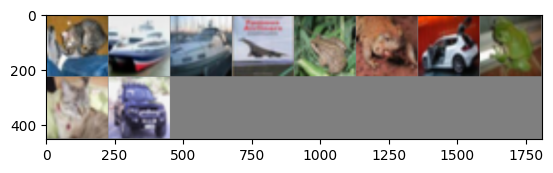

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car  
Predicted:  dog   ship  ship  ship 
Accuracy of the network on the 10000 test test_images: 67 %
Accuracy for class: plane is 73.5 %
Accuracy for class: car   is 88.1 %
Accuracy for class: bird  is 42.3 %
Accuracy for class: cat   is 56.7 %
Accuracy for class: deer  is 65.6 %
Accuracy for class: dog   is 49.7 %
Accuracy for class: frog  is 80.2 %
Accuracy for class: horse is 78.8 %
Accuracy for class: ship  is 83.2 %
Accuracy for class: truck is 65.3 %


In [ ]:
#Cargamos el modelo (el mejor) y evaluamos en un ejemplo
#net = Net()
#net.load_state_dict(torch.load(PATH))

dataiter = iter(testloader)
data = next(dataiter)
test_images, test_labels = data

# print test_images
imshow(torchvision.utils.make_grid(test_images))
print("GroundTruth: ", " ".join(f"{classes[test_labels[j]]:5s}" for j in range(batch_size)))

test_images, test_labels = data[0].to(device), data[1].to(device)
outputs = net(test_images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        test_images, test_labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running test_images through the network
        outputs = net(test_images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()

print(f"Accuracy of the network on the 10000 test test_images: {100 * correct // total} %")


In [ ]:

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        test_images, testloader = data[0].to(device), data[1].to(device)
        outputs = net(test_images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(test_labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")
